In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import shap
import lime
import sklearn 
import warnings
import xgboost
import gc
import multiprocessing as mp
import time
import pickle 
import interpret
import collections
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.preprocessing import LabelEncoder
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostRegressor
%matplotlib inline
import os, sys
#import statsmodels.api as sm
sys.path.append(os.path.abspath("../../../"))

pd.set_option('display.max_columns', None)
import eli5
from eli5.sklearn import PermutationImportance

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
Using TensorFlow backend.


### Load Yale EMC Data
https://github.com/yaleemmlc/admissionprediction

In [2]:
# Data Preprocessing
yale_data = pd.read_csv('yale_emc.csv')
yale_data.drop('Unnamed: 0',axis = 1,inplace = True)
sampled_data = yale_data.sample(5000)
del(yale_data)
gc.collect()
data = sampled_data
target = 'disposition'
cat_cols = ['dep_name','gender','ethnicity','race','lang','religion','maritalstatus'
            ,'employstatus','insurance_status','arrivalmonth','arrivalmonth','arrivalday','previousdispo','arrivalmode']
data = pd.get_dummies(data,columns = cat_cols)
data['arrivalhour_bin'] = [int(x[0]) for x in data['arrivalhour_bin'].str.split('-')]
data.drop('esi',axis = 1, inplace = True)
scaler = preprocessing.StandardScaler()
data['disposition'] = data['disposition'].map({'Discharge':0,'Admit':1})

y = data[target]
cols = data.drop(target,axis = 1).columns
data = scaler.fit_transform(data.drop(target,axis = 1))
data = pd.DataFrame(data,columns = cols)
data = data.loc[:,~data.columns.duplicated()]
data = data.fillna(999)
xTrain, xTest, yTrain, yTest = train_test_split(data,y, test_size = 0.3,random_state = 10)


invalid value encountered in true_divide
Degrees of freedom <= 0 for slice.


### Code for Sparse Ensembles

In [3]:
# Load Required Packages
import sklearn
import statistics
import scipy as sc
import numpy as np
import pandas as pd
import random
import cvxpy as cp
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
import time
import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import mosek
import statsmodels.api as sm

def converge_test(sequence, threshold,length):
    diff = np.diff(sequence)
    if len(diff) < (length+1):
        return False
    else:
        return ( max(np.abs(diff[-length:])) < threshold)
    
def compute_loss(y, y_hat): 
    return ((y - y_hat) ** 2) / 2

def loss_gradient(y, y_hat): 
    return -(y-y_hat) 

def plot_tradeoff_curve(test_acc,nonzero,color,label):
    results = pd.DataFrame()
    for i in range(0,len(test_acc)):
        results = results.append(pd.DataFrame(np.column_stack((test_acc[i],nonzero[i])),columns = ['test_acc','nonzero']))
    agg = results.groupby(['nonzero'], as_index=False).agg({'test_acc':['mean','std','count']})
    
    plt.plot(agg['nonzero'],agg['test_acc']['mean'],color = color,label = label)
    plt.errorbar(agg['nonzero'],agg['test_acc']['mean'], agg['test_acc']['std'],color = color)
    plt.xlabel('Number of Nonzero Features')
    plt.ylabel('Test Error')
    plt.legend()

def build_trees_bag(arg):
    xTrain = arg[0]
    yTrain = arg[1]
    xTest= arg[2]
    yTest= arg[3]
    max_depth= arg[4]
    lambd= arg[5]
    threshold= arg[6] 
    sketch = arg[7]
    problem_type = arg[8]
    #not used
    learning_rate = arg[9]
    n_estimators = arg[10]
    
    train = xTrain
    train = train.reset_index().drop('index',axis = 1)
    train['yTrain'] = list(yTrain)

    features = xTrain.columns
    nfeatures = len(features)
    importance_key = pd.DataFrame(features,columns = ['Features'])
    
    tree_results = []
    i = 0
    depth = 1
    total_trees = 0
    
    for depth in range (1,max_depth+1):
        i = 0
        ### Early Stopping
        early_stop_pred = []
        early_stop_train_err = []
        converged = False
        
        while converged == False:
            train1 = train.sample(n = len(train), replace = True)
        
            yTrain1 = train1['yTrain']
            xTrain1 = train1[features]
            
            if problem_type == 'Regression':
                clf = DecisionTreeRegressor(max_depth = depth)
            elif problem_type == 'Classification':
                clf = DecisionTreeClassifier(max_depth = depth)
        
            clf.fit(xTrain1,yTrain1)
            
            imp = pd.DataFrame(np.column_stack((xTrain1.columns,clf.feature_importances_)), columns = ['Features','Importances'])
            used = imp[imp['Importances']>0]['Features'].values
            feature_indicator = [int(x in used) for x in features]
            pred = clf.predict(xTrain[features])
            feature_importances = pd.merge(importance_key,imp, on = 'Features', how = 'left').fillna(0)['Importances'].values
            test_pred = clf.predict(xTest[features])
            tree_results.append([pred,feature_indicator,feature_importances, test_pred  ,clf,xTrain1,yTrain1,features])
            i = i+1
            total_trees = total_trees+1
            early_stop_pred.append(pred)
            early_stop_train_err.append(np.sqrt(np.mean((np.mean(early_stop_pred,axis = 0) - yTrain)**2)))
            converged = converge_test(early_stop_train_err,10**-2,3)
    
    return tree_results

def solve_step_nonsketch(arg, tree_results):
    
    xTrain = arg[0]
    yTrain = arg[1]
    xTest= arg[2]
    yTest= arg[3]
    max_depth= arg[4]
    lambd= arg[5]
    threshold= arg[6] 
    sketch = arg[7]
    problem_type = arg[8]
    learning_rate = arg[9]
    n_estimators = arg[10]
    feature_list = xTrain.columns
    
    tree_pred = np.transpose(np.array([np.array(row[0]) for row in tree_results]))
    test_pred = np.transpose(np.array([np.array(row[3]) for row in tree_results]))
    indicators = np.transpose(np.array([np.array(row[1]) for row in tree_results]))
    w = cp.Variable(len(tree_results),nonneg=True)
    
    if problem_type == 'Regression':
        
        objective = 0.5 * (1/len(yTrain))*cp.sum_squares(cp.matmul(tree_pred,w)-yTrain) + lambd*cp.norm(cp.matmul(indicators,w),1)
        prob = cp.Problem(cp.Minimize(objective) )
        prob.solve(solver = cp.MOSEK,mosek_params = {mosek.dparam.optimizer_max_time: 100.0} )
        weights = np.asarray(w.value)
        low_values_flags = np.abs(weights) < threshold  
        weights[low_values_flags] = 0 

        tree_ind = np.where(weights >0)[0]
        if len(tree_ind)==0:
            train_error =  np.sqrt(np.mean((yTrain )**2))
            test_error = np.sqrt(np.mean((yTest )**2))
            return([[],test_error,0,train_error])

        importances = np.array([np.array(row[2]) for row in tree_results])
        feature_importances = np.mean(importances[tree_ind],axis = 0)
        nonzero_features = xTrain.columns[np.where(feature_importances >0)[0]]
    
        rf = RandomForestRegressor(n_estimators = 100).fit(xTrain[nonzero_features],yTrain)
        test_pred = rf.predict(xTest[nonzero_features])
        train_pred = rf.predict(xTrain[nonzero_features])
    
        train_error =  np.sqrt(np.mean((yTrain -train_pred)**2))
        test_error = np.sqrt(np.mean((yTest -test_pred)**2))

        return([feature_importances,test_error,len(nonzero_features),train_error])
    
    if problem_type == 'Classification':
        
        loss = -cp.sum(cp.multiply(yTrain, tree_pred@ w) - cp.logistic(tree_pred @ w))
        objective =  (1/len(yTrain))*loss + lambd*cp.norm(cp.matmul(indicators,w),1)
        prob = cp.Problem(cp.Minimize(objective) )
        prob.solve(solver = cp.MOSEK ,mosek_params = {mosek.dparam.optimizer_max_time: 100.0})
        weights = np.asarray(w.value)
        low_values_flags = np.abs(weights) < threshold  # Where values are low
        weights[low_values_flags] = 0
        tree_ind = np.where(weights >0)[0]

        if len(tree_ind)==0:
            train_error =  np.sqrt(np.mean((yTrain )**2))
            test_error = np.sqrt(np.mean((yTest )**2))
            return([[],test_error,0,train_error])

        importances = np.array([np.array(row[2]) for row in tree_results])
        feature_importances = np.mean(importances[tree_ind],axis = 0)
        nonzero_features = xTrain.columns[np.where(feature_importances >0)[0]]
    
        rf = RandomForestClassifier(n_estimators = 100).fit(xTrain[nonzero_features],yTrain)
        
        test_pred = rf.predict_proba(xTest[nonzero_features])[:,1]
        train_pred = rf.predict_proba(xTrain[nonzero_features])[:,1]

        train_error =  0#np.mean(yTrain != train_pred)
        test_error = sklearn.metrics.roc_auc_score(yTest,test_pred)

        return([feature_importances,test_error,len(nonzero_features),train_error])
    
def sparse_tree_ensemble(arg):
    build_tree_method = arg[-1]
    tree_results = build_tree_method(arg)
    return solve_step_nonsketch(arg,tree_results)

def run_experiment(arg,ntrials,nfeatures,threshold):
    pool = Pool(mp.cpu_count())
    test_error_result = []
    nonzero_result = []
    train_error_result = []
    count_array = []
  
    #bisection function
    LL = 0
    RL = 1
    to_find = 0
    counter = 0
    while to_find <= nfeatures:
        try:
            counter = counter + 1 
            trial = 0
            result1= []
            arg_list = []
            lambd = (LL + RL)/2
            while trial < ntrials:
                arg[5] = lambd
                arg_list.append(arg)
                result = sparse_tree_ensemble(arg)
                result1.append(result)
                trial = trial + 1
            #result1 = pool.map(sparse_tree_ensemble, arg_list)
            test_acc = [row[1] for row in result1]
            nonzero = [row[2] for row in result1]

            train_acc = [row[3] for row in result1]

            test_error_result.append(test_acc)
            nonzero_result.append(nonzero)
            count_array = np.append(count_array,nonzero)

            train_error_result.append(train_acc)

            freq = pd.DataFrame(np.column_stack(np.unique(count_array, return_counts = True)),columns = ['value','counts'])
            print(freq.head(10))

            mode_feature_current = np.mean(nonzero)

            count_to_find = freq.loc[freq['value']==to_find]['counts'].values
            print(to_find,mode_feature_current,lambd)

            if len(count_to_find) > 0:
                if count_to_find > threshold:
                    RL = lambd
                    LL = 0
                    to_find = to_find + 1
                    counter = 0

                elif np.abs(mode_feature_current-to_find) >= 1:
                    if mode_feature_current < to_find:
                        RL = lambd 
                    else:
                        LL = lambd

            elif mode_feature_current < to_find:
                RL = lambd
            elif mode_feature_current >= to_find:
                LL = lambd
                
            elif counter >= 10:
                    RL = lambd
                    LL = 0
                    to_find = to_find + 1
                    counter = 0

            print('counter:', counter)
        except:
            print('Solver Failed')
        pool.close()
    return test_error_result,nonzero_result,train_error_result

def baseline(xTrain,yTrain,xTest,yTest,problem_type,nfeatures):
    
    if problem_type == 'Regression':
        model = RandomForestRegressor(n_estimators = 100)
    if problem_type == 'Classification':
            model = RandomForestClassifier(n_estimators = 100)
    
    ### RF feature select baseline
    rf = model.fit(xTrain,yTrain)
    imp = pd.DataFrame(np.column_stack((xTrain.columns,rf.feature_importances_)),columns = ['features','scores']).sort_values('scores',ascending = False)
    print(imp)
    acc =[]
    n_features = []
    se = []
    for i in range(1,nfeatures):
        to_use = imp.head(i)['features'].values
        trial = 0
        acc1 = []
        while trial < 10:
            rf1 = model.fit(xTrain[to_use],yTrain)
            pred = rf1.predict_proba(xTest[to_use])[:,1]
            
            if problem_type == 'Regression':
                acc1.append(np.sqrt(np.mean((yTest-pred)**2)))
                
            if problem_type == 'Classification':
                acc1.append(sklearn.metrics.roc_auc_score(yTest,pred))
                
            trial = trial+1
            
        acc.append(np.mean(acc1))
        se.append(np.std(acc1))
        n_features.append(i)
    return acc,n_features,se

In [4]:
def run_experiment(arg,ntrials,nfeatures,threshold):
    test_error_result = []
    nonzero_result = []
    train_error_result = []
    trial = 0
    while trial < ntrials:
        
        #Build Trees
        build_tree_method = arg[-1]
        tree_results = build_tree_method(arg)
        
        LL = 0
        RL = 1
        to_find = 0
        counter1 = 0
        count_array = []
        while to_find <= nfeatures:
            arg_list = []
            lambd = (LL + RL)/2
            arg[5] = lambd
            result = solve_step_nonsketch(arg,tree_results)
            test_acc = result[1]
            nonzero = result[2]
            train_acc = result[3]
                
            #Append Results
            test_error_result.append(test_acc)
            nonzero_result.append(nonzero)
            train_error_result.append(train_acc)
            count_array.append(nonzero)
        
            freq = pd.DataFrame(np.column_stack(np.unique(count_array, return_counts = True)),columns = ['value','counts'])
            count_to_find = freq.loc[freq['value']==to_find]['counts'].values
            #print(freq.head(10))
            #print('tofind:', to_find)
            #print(to_find,nonzero,lambd, counter1)
             
            if count_to_find > 0 :
                counter1 = 0
                RL = lambd
                LL = 0
                to_find = to_find + 1
            
            elif counter1 >= 10:
                counter1 = 0
                RL = lambd
                LL = 0
                to_find = to_find + 1
               
            elif nonzero < to_find:
                RL = lambd
                counter1 = counter1 + 1 
            
                    
            elif nonzero >= to_find:
                LL = lambd
                counter1 = counter1 + 1 
            
                
            
                
         
                #elif counter >= 10:
                #        RL = lambd
                #        LL = 0
                #        to_find = to_find + 1
                #        counter = 0
                        
            
        trial = trial + 1
     
        
    return test_error_result,nonzero_result,train_error_result

In [5]:
# run experiment
max_depth = 10
threshold = 10**-3
lambd = 0.01
n_estimators = 3
learning_rate = 1
sketch = False
problem_type = 'Classification'

build_tree_method = build_trees_bag
#run_experiment(arg,ntrials,nfeatures,threshold)
arg = [xTrain,yTrain,xTest,yTest,max_depth,lambd,threshold,sketch,problem_type,learning_rate,n_estimators,build_tree_method]
bag_test_acc,bag_nonzero,bag_train_acc = run_experiment(arg,3,15,1)

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty

In [10]:
base_line_acc,baseline_nonzero,baseline_se = baseline(xTrain,yTrain,xTest,yTest,'Classification',40)

                   features     scores
732     meds_cardiovascular  0.0351585
741   meds_gastrointestinal  0.0311723
0                       age  0.0232695
709         meds_analgesics  0.0217953
738          meds_diuretics  0.0159594
..                      ...        ...
214              otrespirca          0
75           ecodesfireburn          0
76          ecodesmachinery          0
122              hodgkinsds          0
711  meds_anti-obesitydrugs          0

[1048 rows x 2 columns]


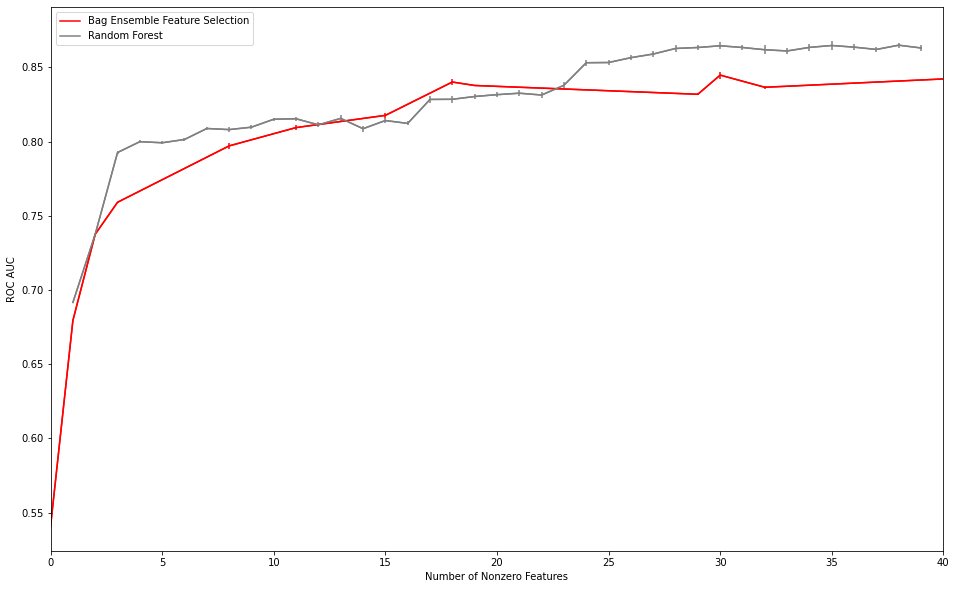

In [13]:
plt.figure(figsize = (16,10))
plot_tradeoff_curve(bag_test_acc,bag_nonzero,'red',label = 'Bag Ensemble Feature Selection')
plt.ylabel('ROC AUC')

plt.plot(baseline_nonzero,base_line_acc,label = 'Random Forest',color = 'grey')
plt.errorbar(baseline_nonzero,base_line_acc, baseline_se,color = 'grey')
plt.xlim(0,40)
plt.legend()